# LSTM

In [301]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, r2_score

In [302]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [303]:
torch.cuda.is_available()

False

In [304]:
device

device(type='cpu')

In [305]:
!nvidia-smi

Sat Oct 19 16:26:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P5              5W /   79W |    1575MiB /   8188MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Define DataSet

In [306]:

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, input_cols, seq_length=4):
        self.data = data
        self.target_col = target_col
        self.input_cols = input_cols
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.input_cols].iloc[idx:idx+self.seq_length].values
        y = self.data[self.target_col].iloc[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define the LSTM model

In [307]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [308]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays_indoor_person_counts.csv')

In [309]:
df.keys()

Index(['DateTime', 'electricity_15min_diff', 'heating_15min_diff',
       'is_holiday', 'day_of_week', 'hour_of_day', 'is_working_hour',
       'number_of_people', 'Temperature', 'Humidity', 'Dewpoint',
       'Sun Duration', 'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [310]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)


In [311]:
df

,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:15:00,1.38,5.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:30:00,1.20,5.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:45:00,1.37,5.0,True,5,0,False,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 01:00:00,1.15,5.0,True,5,1,False,0,11.5,85.0,9.1,0.0,0.0,4.2,220.0,11.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,True,5,23,False,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:15:00,1.64,2.0,True,5,23,False,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:30:00,1.87,3.0,True,5,23,False,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0


In [312]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

# Task1: Predict the heating_15min_diff using the weather data

## using weather data as features

In [313]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [314]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [315]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')



Epoch [1/100], avg_epoch_mse_loss:: 6.3323
Epoch [2/100], avg_epoch_mse_loss:: 2.5625
Epoch [3/100], avg_epoch_mse_loss:: 2.4379
Epoch [4/100], avg_epoch_mse_loss:: 2.3723
Epoch [5/100], avg_epoch_mse_loss:: 2.3328
Epoch [6/100], avg_epoch_mse_loss:: 2.2860
Epoch [7/100], avg_epoch_mse_loss:: 2.2605
Epoch [8/100], avg_epoch_mse_loss:: 2.2475
Epoch [9/100], avg_epoch_mse_loss:: 2.2198
Epoch [10/100], avg_epoch_mse_loss:: 2.2018
Epoch [11/100], avg_epoch_mse_loss:: 2.1825
Epoch [12/100], avg_epoch_mse_loss:: 2.2036
Epoch [13/100], avg_epoch_mse_loss:: 2.1724
Epoch [14/100], avg_epoch_mse_loss:: 2.1610
Epoch [15/100], avg_epoch_mse_loss:: 2.1392
Epoch [16/100], avg_epoch_mse_loss:: 2.1334
Epoch [17/100], avg_epoch_mse_loss:: 2.1177
Epoch [18/100], avg_epoch_mse_loss:: 2.1023
Epoch [19/100], avg_epoch_mse_loss:: 2.0806
Epoch [20/100], avg_epoch_mse_loss:: 2.0758
Epoch [21/100], avg_epoch_mse_loss:: 2.0695
Epoch [22/100], avg_epoch_mse_loss:: 2.0542
Epoch [23/100], avg_epoch_mse_loss:: 2.04

In [316]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.numpy())
        predictions.extend(outputs.numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test  mse Loss: 4.1424
Test RSME Loss: 2.0353
Test MAE: 1.6207
Test R² Score: 0.1444


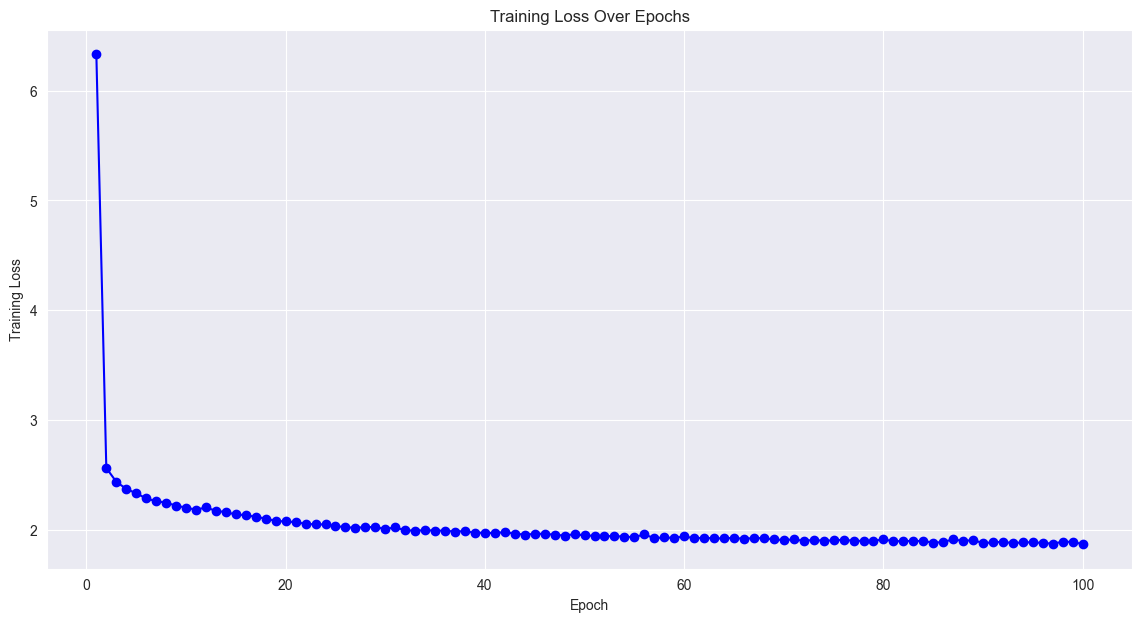

In [317]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

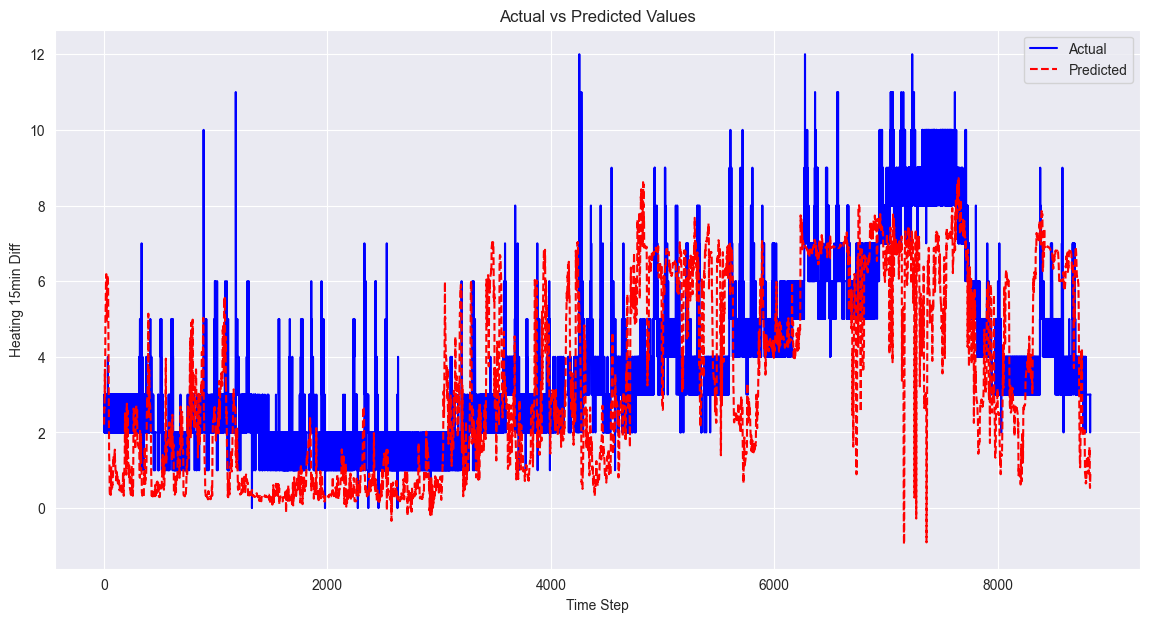

In [318]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Using data with holidays

In [319]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays.csv')

In [320]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [321]:
df

,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:15:00,1.38,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:30:00,1.20,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:45:00,1.37,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 01:00:00,1.15,5.0,1,5,1,0,0,11.5,85.0,9.1,0.0,0.0,4.2,220.0,11.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:15:00,1.64,2.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:30:00,1.87,3.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0


In [322]:
df.keys()

Index(['electricity_15min_diff', 'heating_15min_diff', 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35041 entries, 2022-01-01 00:00:00 to 2023-01-01 00:00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   electricity_15min_diff  35041 non-null  float64
 1   heating_15min_diff      35041 non-null  float64
 2   is_holiday              35041 non-null  int32  
 3   day_of_week             35041 non-null  int32  
 4   hour_of_day             35041 non-null  int32  
 5   is_working_hour         35041 non-null  int32  
 6   number_of_people        35041 non-null  int64  
 7   Temperature             35041 non-null  float64
 8   Humidity                35041 non-null  float64
 9   Dewpoint                35041 non-null  float64
 10  Sun Duration            35041 non-null  float64
 11  Precipitation Height    35041 non-null  float64
 12  Wind Speed              35041 non-null  float64
 13  Wind Direction          35041 non-null  float64
 14  ind

In [324]:
df.index.name

'DateTime'

In [325]:
# df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# df.set_index('DateTime', inplace=True)

In [326]:

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [327]:
# Drop rows with NaN values that may have been introduced by coercion
df.dropna(inplace=True)

In [328]:
# Define the date ranges for training and test data
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

In [329]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [330]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [331]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.numpy())
        predictions.extend(outputs.numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 5.7544
Epoch [2/100], avg_epoch_mse_loss:: 2.3841
Epoch [3/100], avg_epoch_mse_loss:: 2.2303
Epoch [4/100], avg_epoch_mse_loss:: 2.1469
Epoch [5/100], avg_epoch_mse_loss:: 2.0939
Epoch [6/100], avg_epoch_mse_loss:: 2.0602
Epoch [7/100], avg_epoch_mse_loss:: 2.0220
Epoch [8/100], avg_epoch_mse_loss:: 1.9925
Epoch [9/100], avg_epoch_mse_loss:: 1.9644
Epoch [10/100], avg_epoch_mse_loss:: 1.9382
Epoch [11/100], avg_epoch_mse_loss:: 1.9259
Epoch [12/100], avg_epoch_mse_loss:: 1.9185
Epoch [13/100], avg_epoch_mse_loss:: 1.8851
Epoch [14/100], avg_epoch_mse_loss:: 1.8788
Epoch [15/100], avg_epoch_mse_loss:: 1.8770
Epoch [16/100], avg_epoch_mse_loss:: 1.8549
Epoch [17/100], avg_epoch_mse_loss:: 1.8359
Epoch [18/100], avg_epoch_mse_loss:: 1.8291
Epoch [19/100], avg_epoch_mse_loss:: 1.8229
Epoch [20/100], avg_epoch_mse_loss:: 1.8292
Epoch [21/100], avg_epoch_mse_loss:: 1.8133
Epoch [22/100], avg_epoch_mse_loss:: 1.8081
Epoch [23/100], avg_epoch_mse_loss:: 1.78

In [332]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test mse Loss: 3.2768
Test RSME Loss: 1.8102
Test MAE: 1.4268
Test R² Score: 0.3256


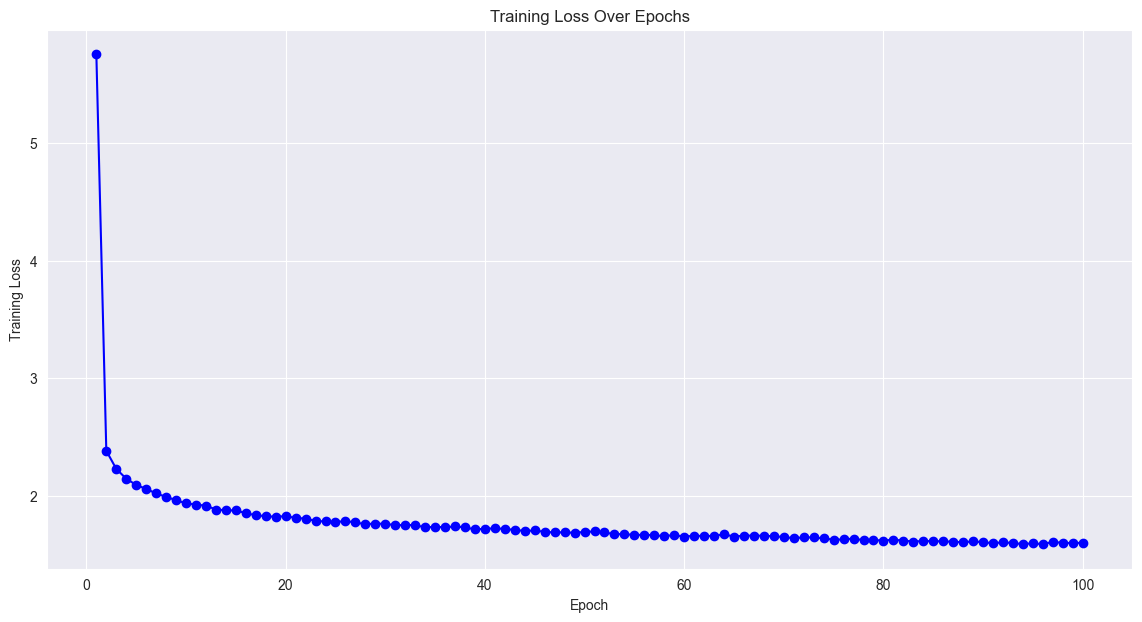

In [333]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

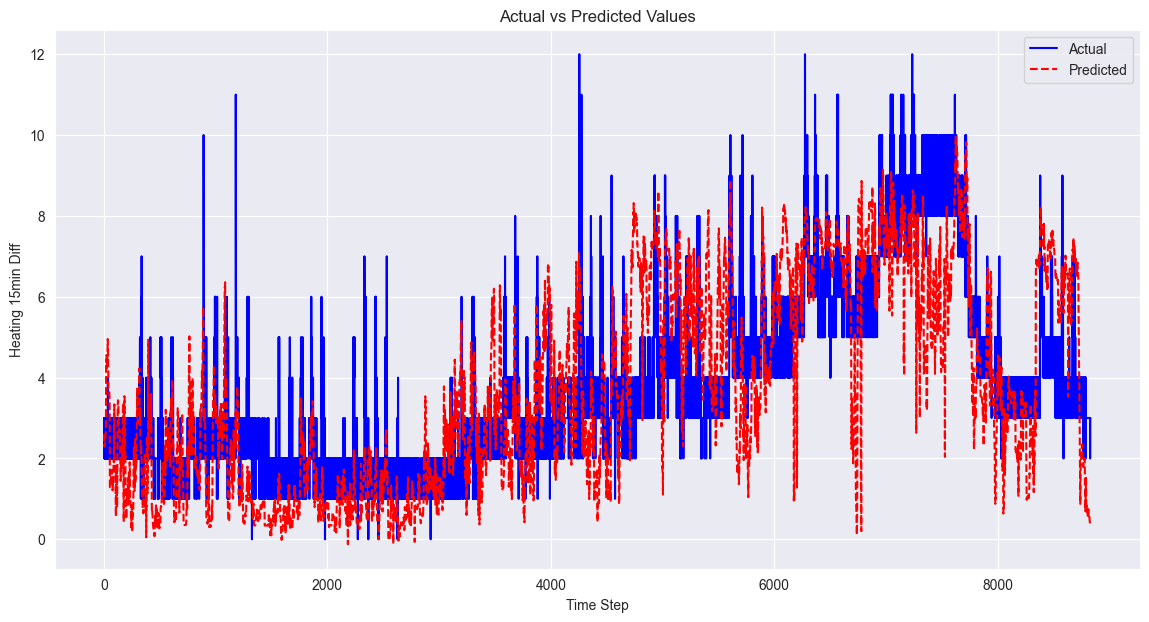

In [334]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [335]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'heating_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [336]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [337]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.numpy())
        predictions.extend(outputs.numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 6.0895
Epoch [2/100], avg_epoch_mse_loss:: 2.4997
Epoch [3/100], avg_epoch_mse_loss:: 2.3115
Epoch [4/100], avg_epoch_mse_loss:: 2.2332
Epoch [5/100], avg_epoch_mse_loss:: 2.1727
Epoch [6/100], avg_epoch_mse_loss:: 2.1302
Epoch [7/100], avg_epoch_mse_loss:: 2.1273
Epoch [8/100], avg_epoch_mse_loss:: 2.0953
Epoch [9/100], avg_epoch_mse_loss:: 2.0744
Epoch [10/100], avg_epoch_mse_loss:: 2.0887
Epoch [11/100], avg_epoch_mse_loss:: 2.0409
Epoch [12/100], avg_epoch_mse_loss:: 2.0261
Epoch [13/100], avg_epoch_mse_loss:: 2.0157
Epoch [14/100], avg_epoch_mse_loss:: 2.0100
Epoch [15/100], avg_epoch_mse_loss:: 1.9891
Epoch [16/100], avg_epoch_mse_loss:: 1.9746
Epoch [17/100], avg_epoch_mse_loss:: 1.9739
Epoch [18/100], avg_epoch_mse_loss:: 1.9603
Epoch [19/100], avg_epoch_mse_loss:: 1.9521
Epoch [20/100], avg_epoch_mse_loss:: 1.9380
Epoch [21/100], avg_epoch_mse_loss:: 1.9371
Epoch [22/100], avg_epoch_mse_loss:: 1.9258
Epoch [23/100], avg_epoch_mse_loss:: 1.91

In [338]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 3.2881
Test RSME Loss: 1.8133
Test MAE: 1.4497
Test R² Score: 0.3236


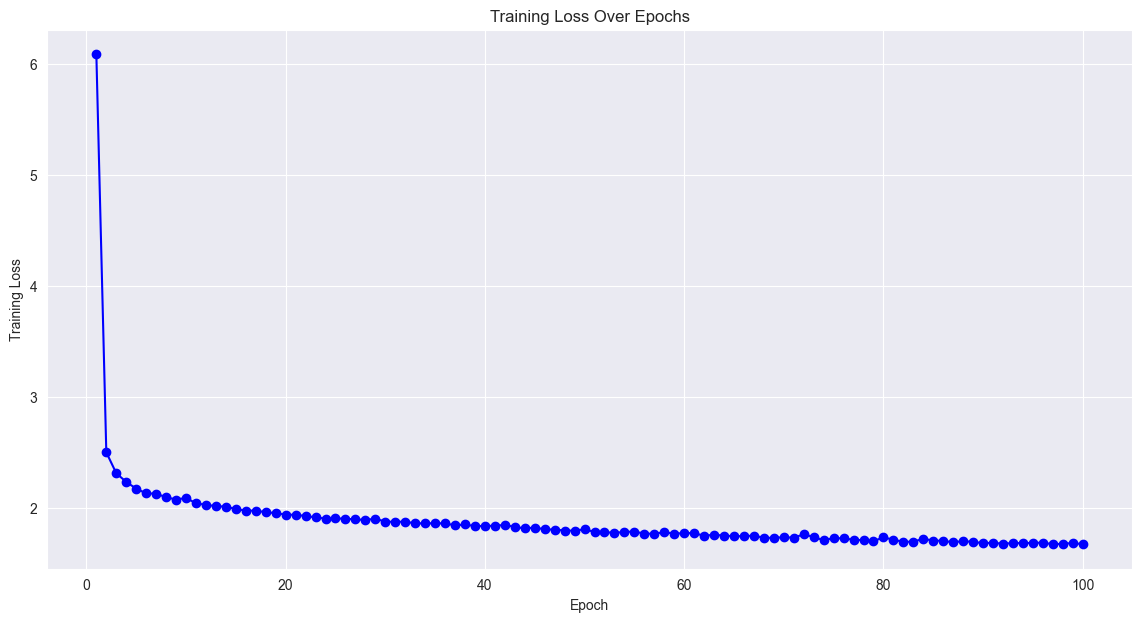

In [339]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

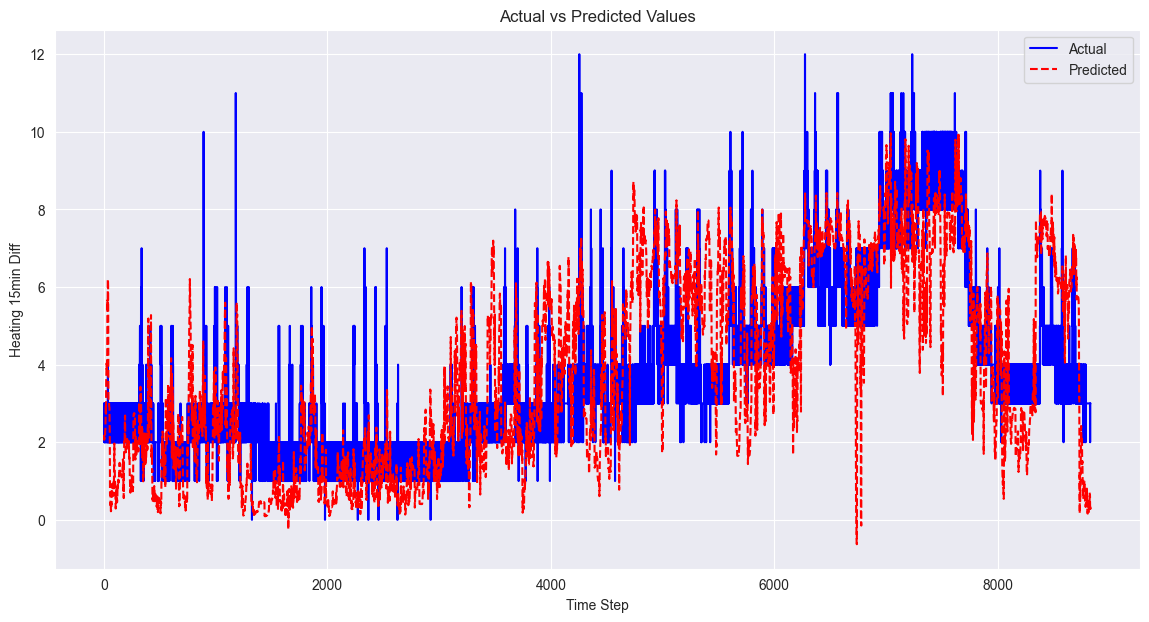

In [340]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Task2: electricity_15min_diff

## using weather data as features

In [341]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [342]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [343]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.3410
Epoch [2/100], avg_epoch_mse_loss:: 11.0275
Epoch [3/100], avg_epoch_mse_loss:: 11.0165
Epoch [4/100], avg_epoch_mse_loss:: 11.0085
Epoch [5/100], avg_epoch_mse_loss:: 11.0009
Epoch [6/100], avg_epoch_mse_loss:: 10.9950
Epoch [7/100], avg_epoch_mse_loss:: 10.9851
Epoch [8/100], avg_epoch_mse_loss:: 10.9880
Epoch [9/100], avg_epoch_mse_loss:: 10.9880
Epoch [10/100], avg_epoch_mse_loss:: 10.9832
Epoch [11/100], avg_epoch_mse_loss:: 10.9737
Epoch [12/100], avg_epoch_mse_loss:: 10.9797
Epoch [13/100], avg_epoch_mse_loss:: 10.9767
Epoch [14/100], avg_epoch_mse_loss:: 10.9756
Epoch [15/100], avg_epoch_mse_loss:: 10.9686
Epoch [16/100], avg_epoch_mse_loss:: 10.9649
Epoch [17/100], avg_epoch_mse_loss:: 10.9540
Epoch [18/100], avg_epoch_mse_loss:: 10.9542
Epoch [19/100], avg_epoch_mse_loss:: 10.9572
Epoch [20/100], avg_epoch_mse_loss:: 10.9498
Epoch [21/100], avg_epoch_mse_loss:: 10.9607
Epoch [22/100], avg_epoch_mse_loss:: 10.9495
Epoch [23/100], avg

In [344]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 1.1276
Test RSME Loss: 1.0619
Test MAE: 0.7666
Test R² Score: -0.1354


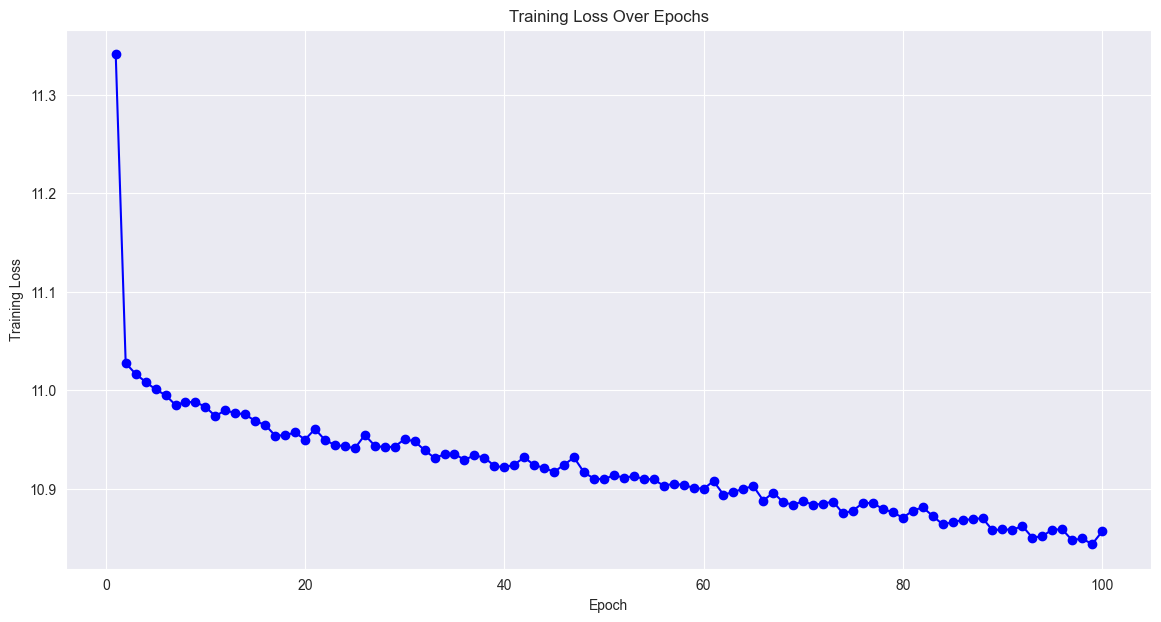

In [345]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

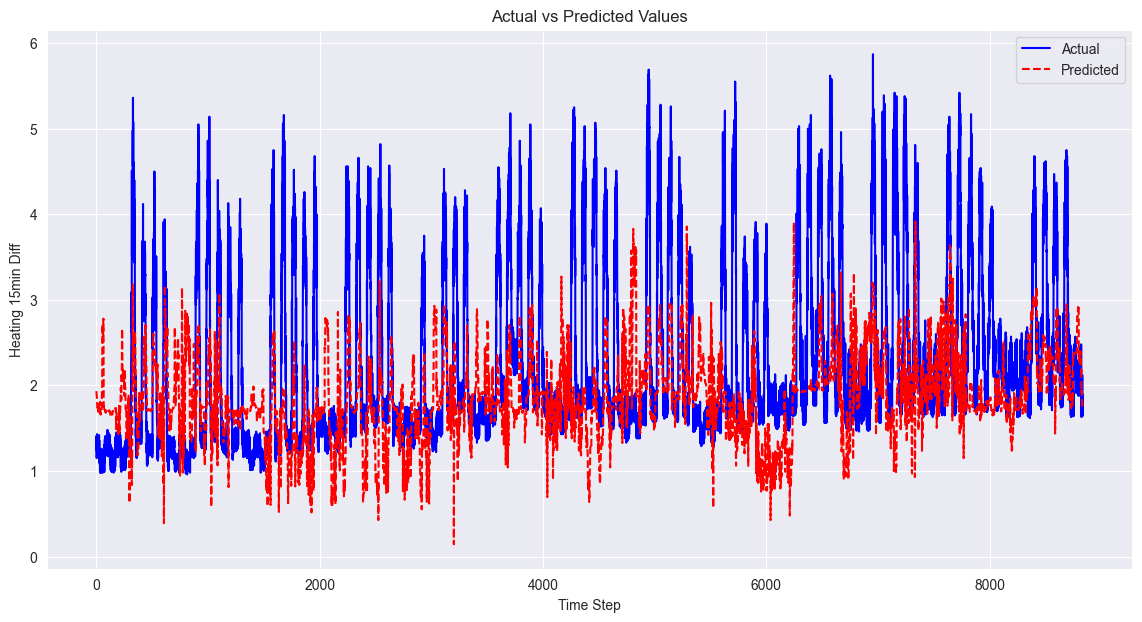

In [346]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using data with holidays

In [347]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [348]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [349]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.2853
Epoch [2/100], avg_epoch_mse_loss:: 10.7154
Epoch [3/100], avg_epoch_mse_loss:: 10.6189
Epoch [4/100], avg_epoch_mse_loss:: 10.5931
Epoch [5/100], avg_epoch_mse_loss:: 10.6089
Epoch [6/100], avg_epoch_mse_loss:: 10.5474
Epoch [7/100], avg_epoch_mse_loss:: 10.5186
Epoch [8/100], avg_epoch_mse_loss:: 10.5813
Epoch [9/100], avg_epoch_mse_loss:: 10.5423
Epoch [10/100], avg_epoch_mse_loss:: 10.5120
Epoch [11/100], avg_epoch_mse_loss:: 10.5236
Epoch [12/100], avg_epoch_mse_loss:: 10.5125
Epoch [13/100], avg_epoch_mse_loss:: 10.4867
Epoch [14/100], avg_epoch_mse_loss:: 10.4973
Epoch [15/100], avg_epoch_mse_loss:: 10.5085
Epoch [16/100], avg_epoch_mse_loss:: 10.4762
Epoch [17/100], avg_epoch_mse_loss:: 10.4726
Epoch [18/100], avg_epoch_mse_loss:: 10.4597
Epoch [19/100], avg_epoch_mse_loss:: 10.4591
Epoch [20/100], avg_epoch_mse_loss:: 10.4591
Epoch [21/100], avg_epoch_mse_loss:: 10.4800
Epoch [22/100], avg_epoch_mse_loss:: 10.4716
Epoch [23/100], avg

In [350]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 0.4084
Test RSME Loss: 0.6391
Test MAE: 0.4789
Test R² Score: 0.5901


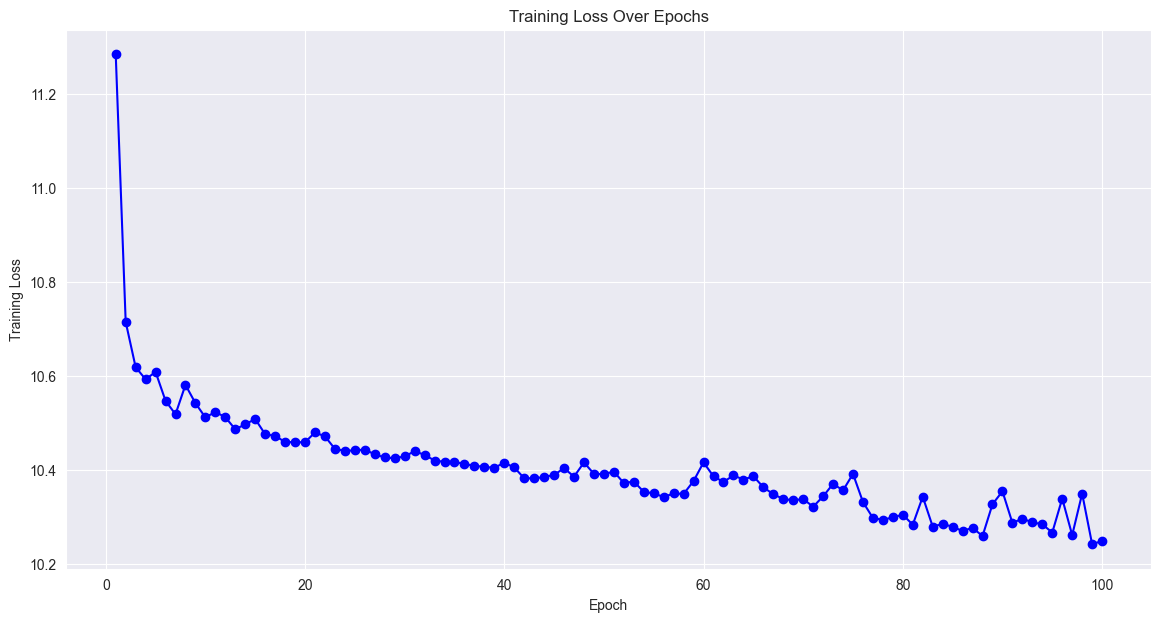

In [351]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

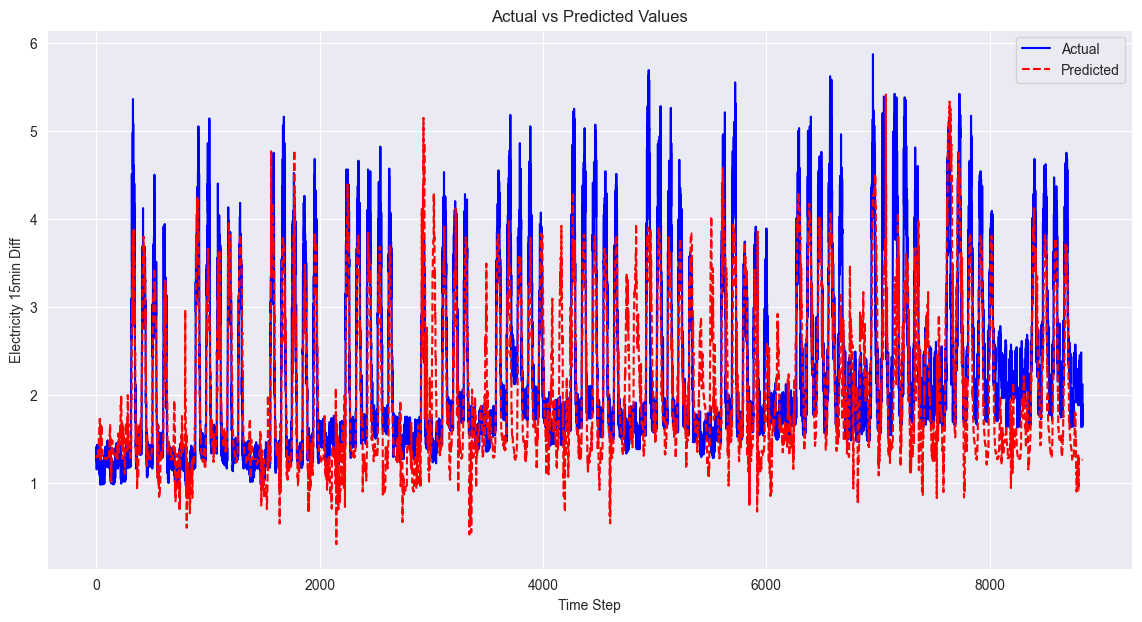

In [352]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [353]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'electricity_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [354]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [355]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 10.9763
Epoch [2/100], avg_epoch_mse_loss:: 10.6349
Epoch [3/100], avg_epoch_mse_loss:: 10.5816
Epoch [4/100], avg_epoch_mse_loss:: 10.5741
Epoch [5/100], avg_epoch_mse_loss:: 10.5332
Epoch [6/100], avg_epoch_mse_loss:: 10.5328
Epoch [7/100], avg_epoch_mse_loss:: 10.5125
Epoch [8/100], avg_epoch_mse_loss:: 10.4959
Epoch [9/100], avg_epoch_mse_loss:: 10.4936
Epoch [10/100], avg_epoch_mse_loss:: 10.4825
Epoch [11/100], avg_epoch_mse_loss:: 10.4869
Epoch [12/100], avg_epoch_mse_loss:: 10.4940
Epoch [13/100], avg_epoch_mse_loss:: 10.4906
Epoch [14/100], avg_epoch_mse_loss:: 10.4812
Epoch [15/100], avg_epoch_mse_loss:: 10.4627
Epoch [16/100], avg_epoch_mse_loss:: 10.4779
Epoch [17/100], avg_epoch_mse_loss:: 10.4737
Epoch [18/100], avg_epoch_mse_loss:: 10.4795
Epoch [19/100], avg_epoch_mse_loss:: 10.4607
Epoch [20/100], avg_epoch_mse_loss:: 10.4622
Epoch [21/100], avg_epoch_mse_loss:: 10.4516
Epoch [22/100], avg_epoch_mse_loss:: 10.4449
Epoch [23/100], avg

In [356]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 0.3653
Test RSME Loss: 0.6044
Test MAE: 0.4569
Test R² Score: 0.6336


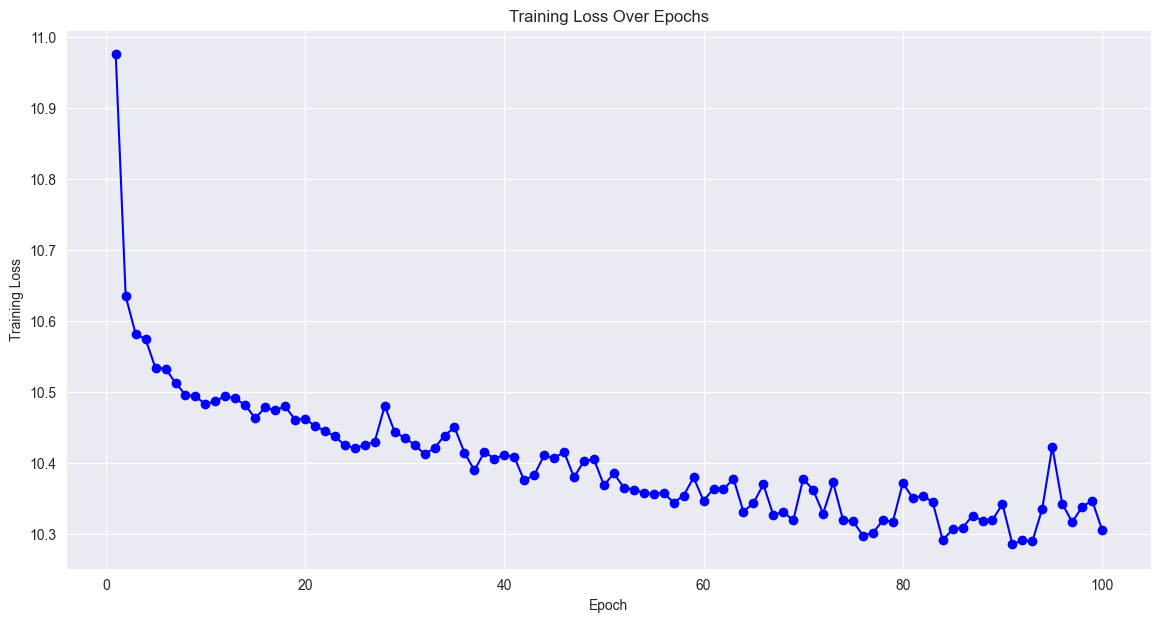

In [357]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

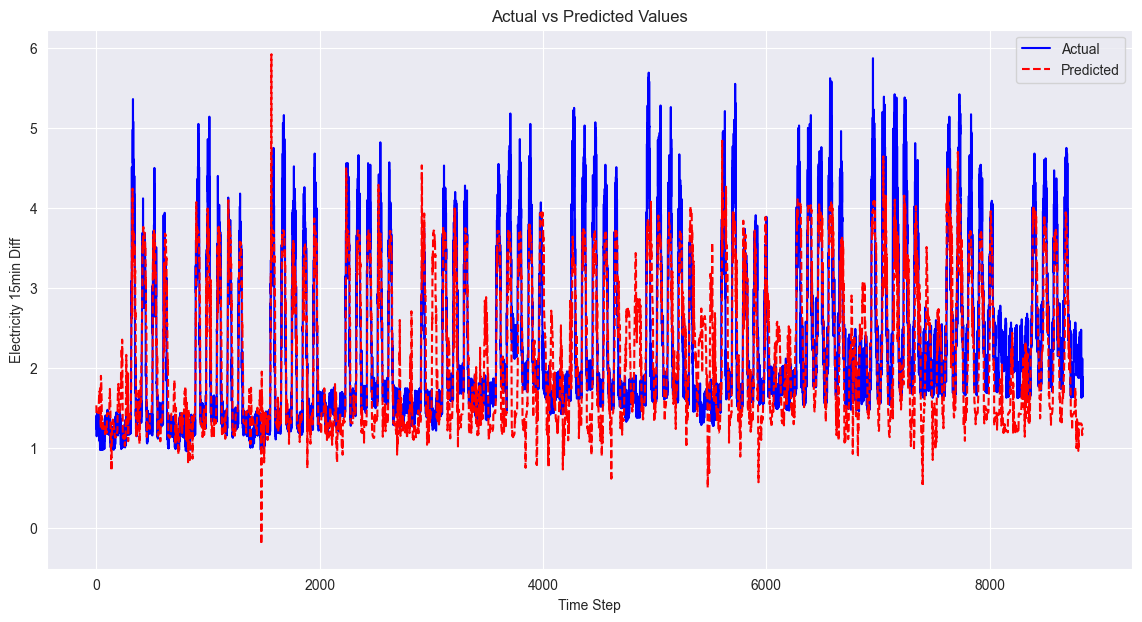

In [358]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()